In [59]:
from api import read, Well
from droplet_growth import multiwell, fit, projections, count
import numpy as np
import pims_nd2 as nd
from tqdm.auto import tqdm
from tifffile import imread, imwrite
from scipy.ndimage import gaussian_filter, binary_erosion, binary_fill_holes, label, binary_dilation
from skimage.measure import regionprops, regionprops_table
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from nd2tif import transform
from tifffile import imread
import seaborn as sns
import pandas as pd
import os
from skimage import io
from PIL import Image
from functools import reduce
from operator import add

In [3]:
import matplotlib.pyplot as plt

In [4]:
import sys
sys.version

'3.8.3 (default, May 19 2020, 18:47:26) \n[GCC 7.3.0]'

In [5]:
def show(bf, cmap='gray', **kwargs):
    plt.figure(figsize=(15,10), dpi=150)
    plt.imshow(bf, cmap=cmap, **kwargs)

In [39]:
FRAME_RATE_MIN = 30 #min

In [6]:
bf_path = '/home/aaristov/Multicell/SGR/MIP/t01z01c1.tif'

In [7]:
bf = imread(bf_path)

(3145, 10552)
506  regions
10  bad regions
496 good regions


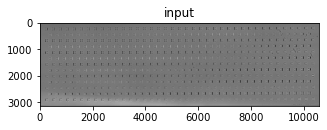

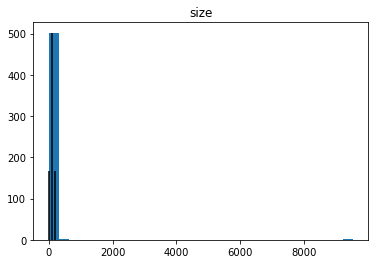

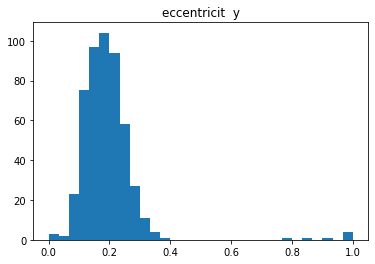

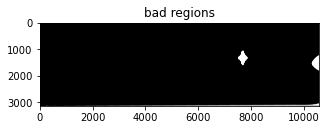

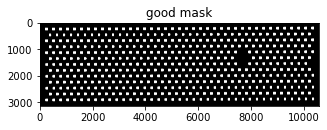

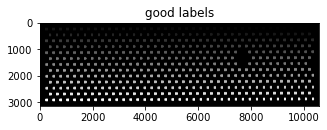

In [8]:
reader = bf
print(reader.shape)
mask = multiwell.get_mask(
    reader, 
    erode=20, 
    thr=0.05, 
    size_lim=(10, 200), 
    eccentricity_lim=.5,
    post_dilate=2,
    structure=np.ones((8,8)),
    figsize=(5,5)
)

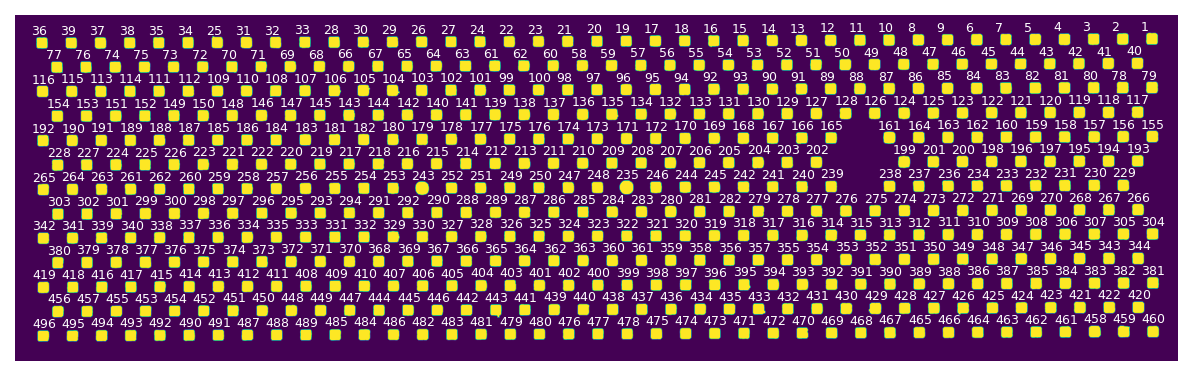

In [9]:
centers = multiwell.get_centers(mask, shift_labels=(-100,-80), color='w')

In [47]:
ppp = projections.get_max_mean_projections(folder='/home/aaristov/Multicell/SGR/20200807-CIPRO-7ngml/Images/', 
                                    output='/home/aaristov/Multicell/SGR/20200807-CIPRO-7ngml/',
                                    channels=(3,),
                                    )

Virtial Stack instance. 
Found 2793 files in /home/aaristov/Multicell/SGR/20200807-CIPRO-7ngml/Images/. 
Ranges: {'t': {'min': 1, 'max': 49}, 'z': {'min': 1, 'max': 19}, 'c': {'min': 1, 'max': 3}}
channel 3
assembling z projections for t-series (1, 49): 
.................................................
saved data to `/home/aaristov/Multicell/SGR/20200807-CIPRO-7ngml/max_projection_c3.tif`

saved data to `/home/aaristov/Multicell/SGR/20200807-CIPRO-7ngml/mean_projection_c3.tif`


(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 496)

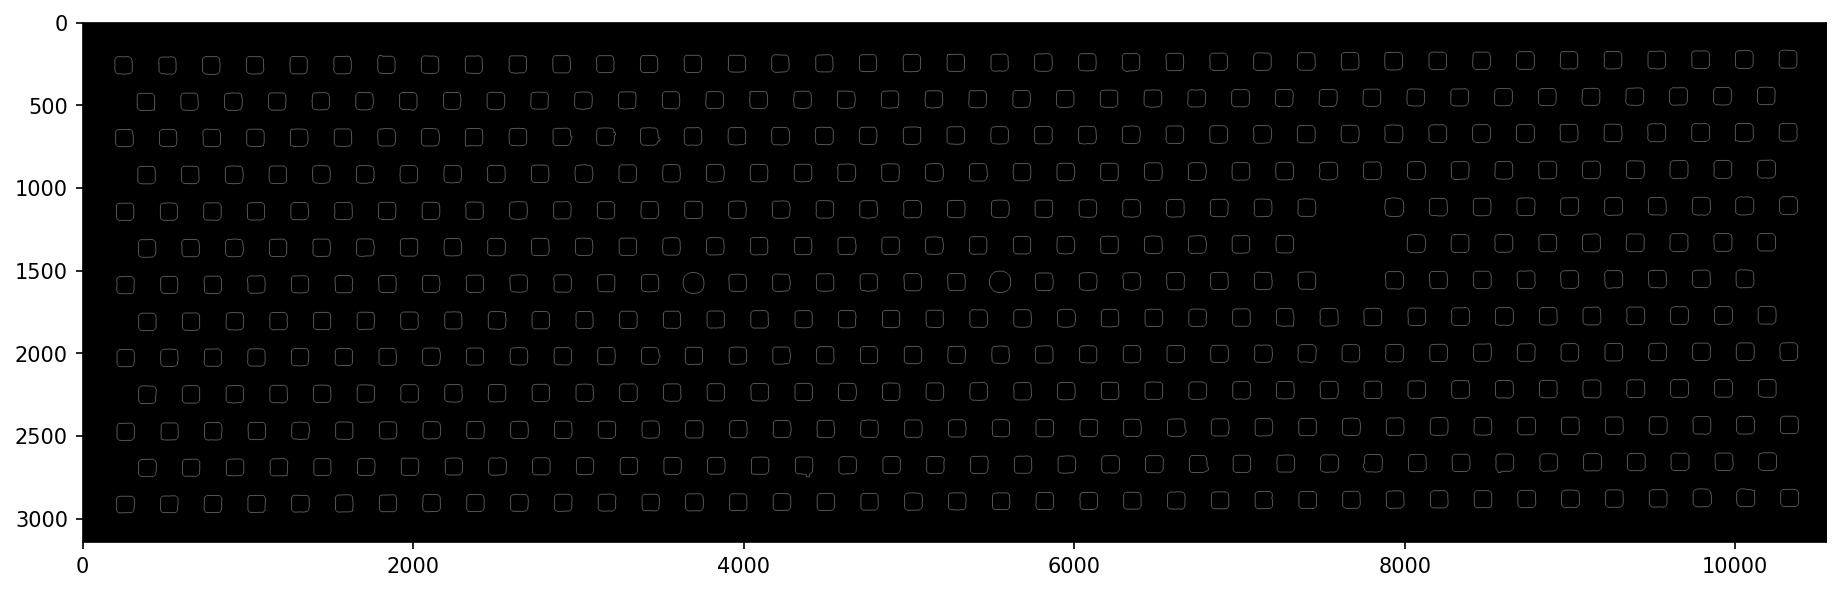

In [10]:
outlines = np.logical_xor(m := (mask > 0), binary_dilation(m, iterations=2))
show(outlines)
label(outlines)

### MAKE SURE THE LABELS ARE THE SAME!!!

Text(0.5, 1.0, 'RFP control')

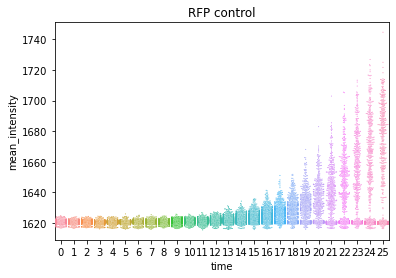

In [11]:
rfp_z_sum = imread('/home/aaristov/Multicell/SGR/202008-confocal/0805-control/mean_projection_c2.tif')
rfp_table = multiwell.get_intensity_table(mask, rfp_z_sum, 
                                          values=['mean_intensity', 'intensity_image'])
plt.title('RFP control')
# plt.ylim(300, 1700)

In [12]:
rfp_bg = multiwell.get_intensity_table(label(outlines)[0], rfp_z_sum, plot=0, 
                                       )
# plt.title('RFP bg')
# plt.ylim(300, 1700)

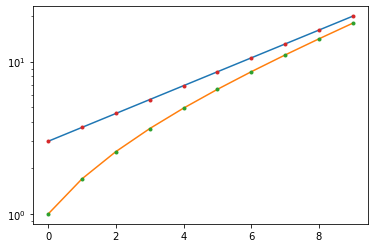

In [13]:
x = np.arange(10)
y = 3 * np.exp(x * 0.21)
y2 = y-2
plt.semilogy(y)
plt.semilogy(y2)


popt = fit.fit_exp_on_baseline(y2)
plt.semilogy(x, fit.exp_on_baseline(x, *popt), '.')
plt.semilogy(x, fit.exp_on_baseline(x, 0, *popt[1:]), '.')

In [14]:
from functools import partial

In [20]:
rfp_table

time label  mean_intensity  \
0      0     1     1621.570828   
1      0     2     1621.738411   
2      0     3     1621.295997   
3      0     4     1621.661773   
4      0     5     1621.095591   
..   ...   ...             ...   
491   25   492     1620.823293   
492   25   493     1668.693122   
493   25   494     1620.949714   
494   25   495     1620.347442   
495   25   496     1685.235775   

                                       intensity_image  
0    [[1531, 1531, 1531, 1531, 1531, 1531, 1531, 15...  
1    [[1540, 1540, 1540, 1540, 1540, 1540, 1540, 15...  
2    [[1528, 1528, 1528, 1528, 1528, 1528, 1528, 15...  
3    [[1543, 1543, 1543, 1543, 1543, 1543, 1543, 15...  
4    [[1542, 1542, 1542, 1542, 1542, 1542, 1542, 15...  
..                                                 ...  
491  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16...  
492  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
493  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
494  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
495  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  

[12896 rows x 4 columns]

In [21]:
rfp_bg

time label  mean_intensity
0      0     1     1621.413102
1      0     2     1621.118919
2      0     3     1621.937838
3      0     4     1622.013477
4      0     5     1621.346467
..   ...   ...             ...
491   25   492     1620.711749
492   25   493     1620.904255
493   25   494     1621.465847
494   25   495     1620.011019
495   25   496     1621.811295

[12896 rows x 3 columns]

In [35]:
rfp_table_all = rfp_bg[['time', 'label']]
rfp_table_all['dye'] = 'RFP'
rfp_table_all['bg'] = rfp_bg.mean_intensity
rfp_table_all['raw'] = rfp_table.mean_intensity
rfp_table_all['mean_intensity'] = rfp_table.mean_intensity - rfp_bg.mean_intensity
rfp_table_all.to_csv('/home/aaristov/Multicell/SGR/202008-confocal/0805-control/intensities.csv', index=None)

ID: 1
RFP


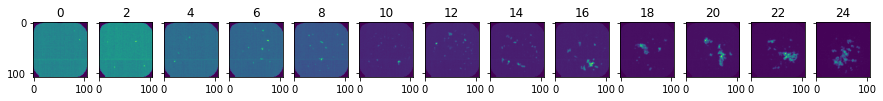

No handles with labels found to put in legend.


[-0.31106135  0.25916362  0.2296836 ]
chi2: 0.24398859768950557
ID: 2
RFP


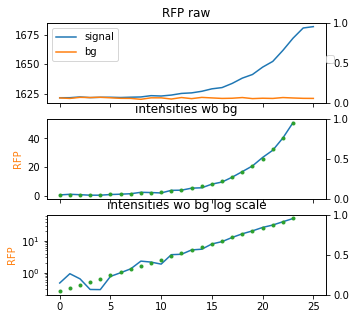

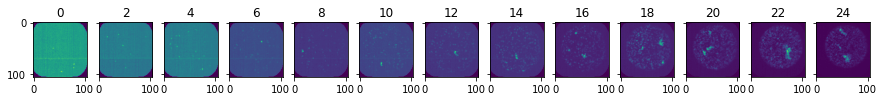

No handles with labels found to put in legend.


[-0.02128707  0.35680921  0.22311319]
chi2: 0.5098863735065642
ID: 3
RFP


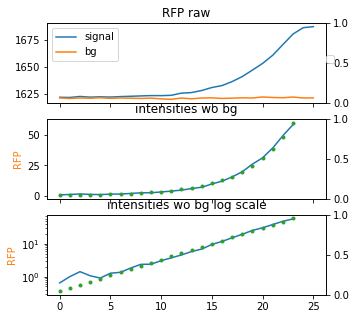

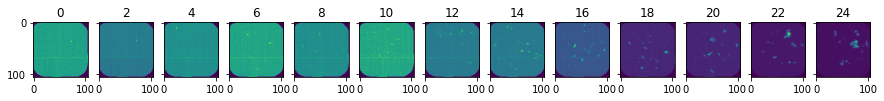

No handles with labels found to put in legend.


[-0.78658258  0.02644648  0.27084211]
chi2: 1.0234112338893444
ID: 4
RFP


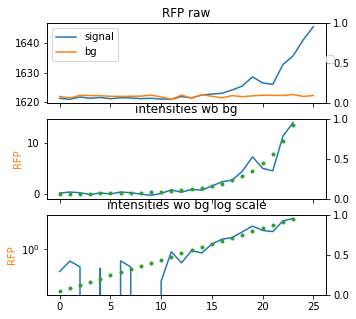

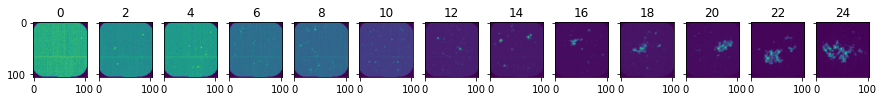

No handles with labels found to put in legend.


[-0.24999772  0.10718783  0.27815354]
chi2: 4.326811021764832
ID: 5
RFP


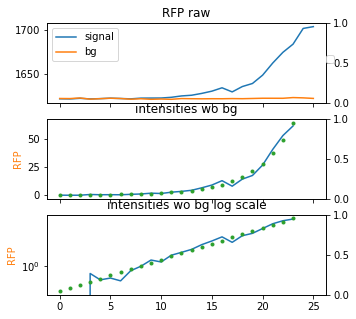

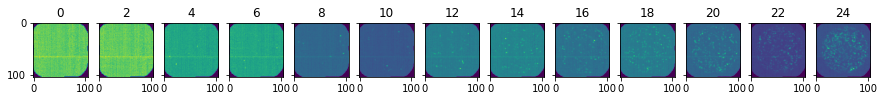

No handles with labels found to put in legend.


[-0.35553467  0.04724383  0.22010266]
chi2: 0.054898258466728196
ID: 6
No signal: 0.6196401005522603 < 1.9900142453402712


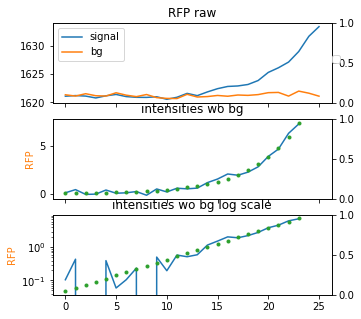

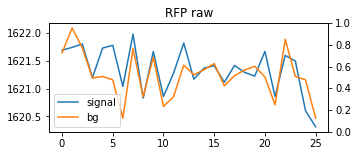

ID: 7
RFP


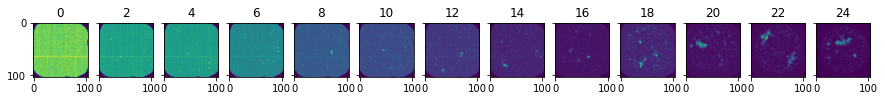

No handles with labels found to put in legend.


[-0.2771106   0.14087003  0.25967464]
chi2: 1.6816542443600389
ID: 8
RFP


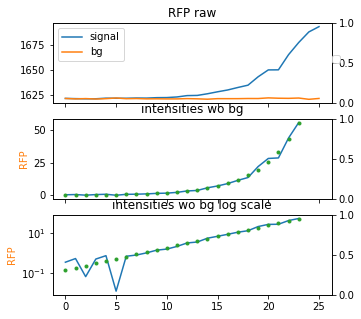

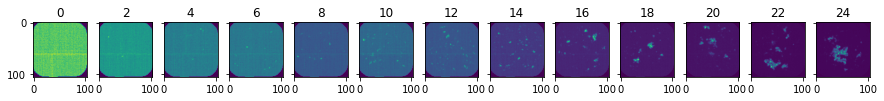

No handles with labels found to put in legend.


[-0.60064755  0.16098335  0.23459125]
chi2: 2.3274266366702316
ID: 9
RFP


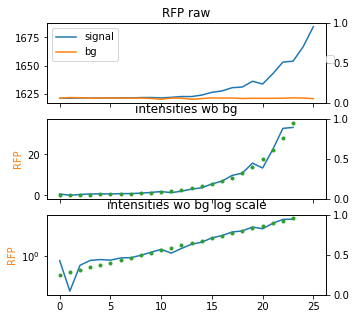

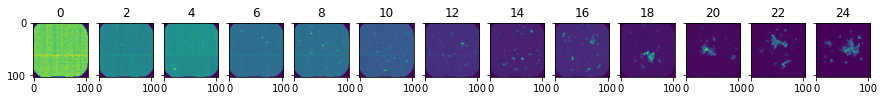

No handles with labels found to put in legend.


[-1.47611097  0.4129883   0.21027889]
chi2: 3.416504408835094
ID: 10
RFP


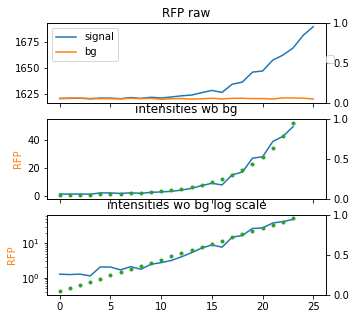

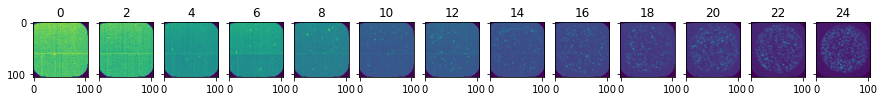

No handles with labels found to put in legend.


[-1.27320091  0.05517506  0.27402933]
chi2: 0.05554422313697065


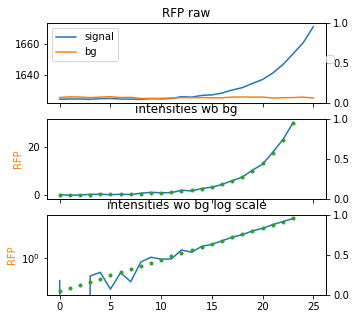

In [101]:
fun = partial(
    multiwell.analyse_curves, dyes=['RFP',], 
    intensity_tables=[rfp_table,], 
    bg_tables=[rfp_bg,],
    meta_table=None, 
    plot=True, 
    fit_fun=fit.fit_exp_on_baseline, 
    gen_fun=fit.exp_on_baseline, 
    stop=24
)
fits_list = list(map(fun, rfp_table.label[:].unique()[:10]))


In [16]:
len(rfp_table.label[:].unique())

496

In [55]:
all_fits = pd.DataFrame(list(reduce(add, fits_list)))

In [56]:
all_fits 

id  dye         a         b         c      chi2  \
0      1  RFP -0.311061  0.259164  0.229684  0.243989   
1      2  RFP -0.021287  0.356809  0.223113  0.509886   
2      3  RFP -0.786583  0.026446  0.270842  1.023411   
3      4  RFP -0.249998  0.107188  0.278154  4.326811   
4      5  RFP -0.355535  0.047244  0.220103  0.054898   
..   ...  ...       ...       ...       ...       ...   
491  492  RFP       NaN       NaN       NaN       NaN   
492  493  RFP  0.064362  0.074897  0.260926  0.190364   
493  494  RFP       NaN       NaN       NaN       NaN   
494  495  RFP       NaN       NaN       NaN       NaN   
495  496  RFP -2.603164  0.734577  0.196615  1.826230   

                                                 curve  stop   max_grad  \
0    [0.1577266710044114, 0.6109130058530354, 0.323...  24.0   9.847792   
1    [0.6194916771075896, 0.9751463857423914, 1.392...  24.0   9.877342   
2    [-0.6418409171296844, -0.43472161537965803, -0...  24.0   4.951694   
3    [-0.3517039716941781, -0.40165656420322193, -0...  24.0  13.663775   
4    [-0.25087632468898846, 0.08243991813287721, -0...  24.0   2.263670   
..                                                 ...   ...        ...   
491                                                NaN   NaN        NaN   
492  [0.34990396644843713, 0.0257539576336967, -0.2...  24.0  11.982829   
493                                                NaN   NaN        NaN   
494                                                NaN   NaN        NaN   
495  [-0.47483891301294534, -0.9083413376556564, -0...  24.0   9.123890   

                                               comment  
0                                                  NaN  
1                                                  NaN  
2                                                  NaN  
3                                                  NaN  
4                                                  NaN  
..                                                 ...  
491  (No signal: 0.11154453881090376 < 2.5037321711...  
492                                                NaN  
493  (No signal: 0.48926473583333063 < 2.5895799369...  
494  (No signal: 0.5525236307264549 < 2.63553782766...  
495                                                NaN  

[496 rows x 10 columns]

In [67]:
all_fits_rate = fit.add_doubling_time(all_fits, frame_rate=30)

In [68]:
all_fits_rate

id  dye         a         b         c      chi2  \
0      1  RFP -0.311061  0.259164  0.229684  0.243989   
1      2  RFP -0.021287  0.356809  0.223113  0.509886   
2      3  RFP -0.786583  0.026446  0.270842  1.023411   
3      4  RFP -0.249998  0.107188  0.278154  4.326811   
4      5  RFP -0.355535  0.047244  0.220103  0.054898   
..   ...  ...       ...       ...       ...       ...   
491  492  RFP       NaN       NaN       NaN       NaN   
492  493  RFP  0.064362  0.074897  0.260926  0.190364   
493  494  RFP       NaN       NaN       NaN       NaN   
494  495  RFP       NaN       NaN       NaN       NaN   
495  496  RFP -2.603164  0.734577  0.196615  1.826230   

                                                 curve  stop   max_grad  \
0    [0.1577266710044114, 0.6109130058530354, 0.323...  24.0   9.847792   
1    [0.6194916771075896, 0.9751463857423914, 1.392...  24.0   9.877342   
2    [-0.6418409171296844, -0.43472161537965803, -0...  24.0   4.951694   
3    [-0.3517039716941781, -0.40165656420322193, -0...  24.0  13.663775   
4    [-0.25087632468898846, 0.08243991813287721, -0...  24.0   2.263670   
..                                                 ...   ...        ...   
491                                                NaN   NaN        NaN   
492  [0.34990396644843713, 0.0257539576336967, -0.2...  24.0  11.982829   
493                                                NaN   NaN        NaN   
494                                                NaN   NaN        NaN   
495  [-0.47483891301294534, -0.9083413376556564, -0...  24.0   9.123890   

                                               comment  Doubling time, min  
0                                                  NaN          130.614461  
1                                                  NaN          134.460896  
2                                                  NaN          110.765640  
3                                                  NaN          107.854101  
4                                                  NaN          136.300037  
..                                                 ...                 ...  
491  (No signal: 0.11154453881090376 < 2.5037321711...                 NaN  
492                                                NaN          114.974919  
493  (No signal: 0.48926473583333063 < 2.5895799369...                 NaN  
494  (No signal: 0.5525236307264549 < 2.63553782766...                 NaN  
495                                                NaN          152.582543  

[496 rows x 11 columns]

In [51]:
all_fits_rate.to_csv('/home/aaristov/Multicell/SGR/202008-confocal/0805-control/exp_fits.csv', index=None)

In [43]:
all_fits_rate = pd.read_csv('/home/aaristov/Multicell/SGR/202008-confocal/0805-control/exp_fits.csv')

/home/aaristov/miniconda3/envs/nd2/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/aaristov/miniconda3/envs/nd2/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


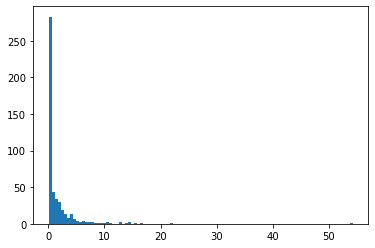

In [56]:
_ = plt.hist(all_fits.chi2.values, bins=100)

In [43]:
print(f'{len(all_fits.query("c > 0.1")) / (tot := len(all_fits)):.1%} positives out of {tot} droplets')

70.6% positives out of 496 droplets


In [52]:
fits = all_fits.query('c > 0').query('chi2 < 10')

In [45]:
fits.to_csv('/home/aaristov/Multicell/SGR/202008-confocal/0805-control/good_exp_fits.csv', index=None)

In [53]:
_ = plt.hist((ttt := fits['Doubling time, min'].values), bins=50)
plt.title('Doubling time')
plt.xlabel('Doubling time, min')
print(f'Doubling time {ttt.mean():.1f} minutes')

Doubling time 116.5 minutes


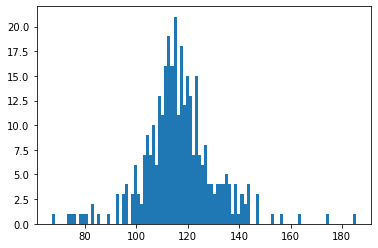

In [47]:
_ = plt.hist(fits['Doubling time, min'].values, bins=100)

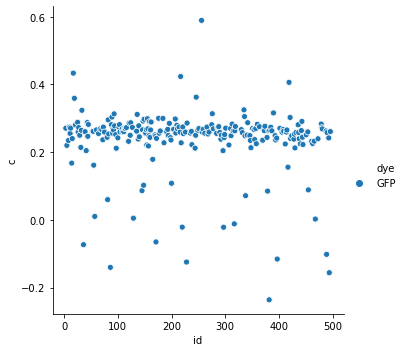

In [133]:
sns.relplot(x='id', y='c', hue='dye', data=fits)

In [148]:
stack = rfp_table.loc[0].intensity_image.values

In [388]:
from skimage.feature import peak_local_max
from scipy import ndimage as ndi

def crop(stack, center, size):
    im = stack[:, int(center[0]) - size//2:int(center[0]) + size//2, int(center[1]) - size//2:int(center[1]) + size//2]
    return im

def get_peak_number(crop2d, dif_gauss_sigma=(1, 3), min_distance=5, threshold_abs=5, plot=False):
    image_max = ndi.gaussian_filter(crop2d, sigma=dif_gauss_sigma[0]) - ndi.gaussian_filter(im, sigma=dif_gauss_sigma[1])
    peaks = peak_local_max(image_max, min_distance=min_distance, threshold_abs = threshold_abs)
    
    if plot:
        plt.imshow(image_max)
        plt.plot(peaks[:,1], peaks[:,0], 'r.')
        plt.show()
    return len(peaks)

def get_peaks(stack, dif_gauss_sigma=(1, 3), **kwargs):
    image_ref = ndi.gaussian_filter(stack[0], sigma=dif_gauss_sigma[0]) - ndi.gaussian_filter(stack[0], sigma=dif_gauss_sigma[1])
    thr = 3 * image_ref.std()
    return list(map(partial(get_peak_number, threshold_abs=thr, **kwargs), stack))

In [389]:
def get_peaks_all_wells(stack, centers):
    n_peaks = []
    for c in centers:
        print('.', end='')
        well = crop(rfp_z_sum, c['center'], 100)
        n_peaks.append(get_peaks(well, plot=0))
    return n_peaks

In [276]:
thr = rfp_z_sum[0].std()
thr

73.12037386781552

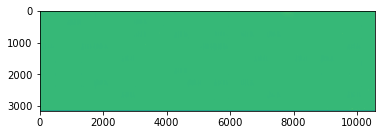

In [277]:
plt.imshow(rfp_z_sum[0])

-0.0115 1.1775261143601021 4
0.0155 1.165014914067627 7


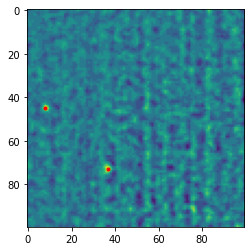

0.004 1.1589581528252002 10


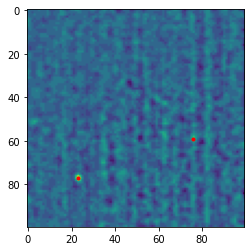

0.0054 1.1979861601871702 5


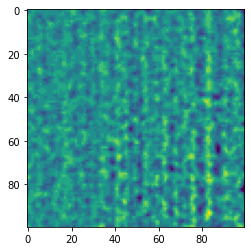

-0.0043 1.2167503893568312 14


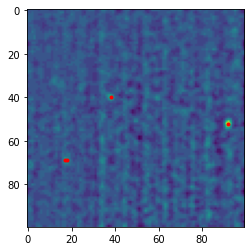

-0.0071 1.1897266871008652 7


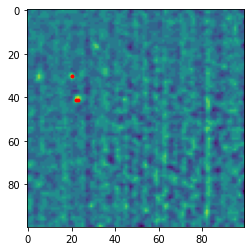

0.0023 1.3232137809137268 25


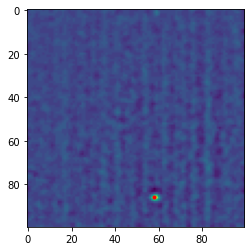

0.0004 1.3398506782473933 23


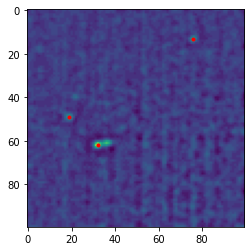

-0.0093 1.1894593351603073 11


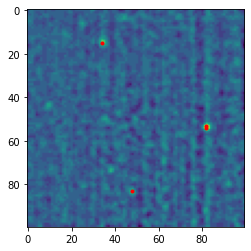

-0.0016 1.4353387892758978 19


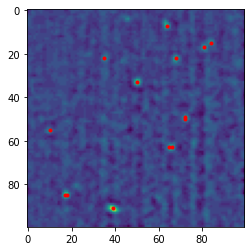

-0.0127 1.3486062101295544 21


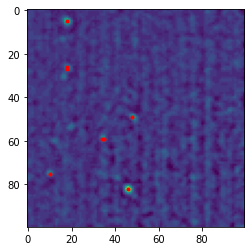

0.0037 1.4914041403992413 23


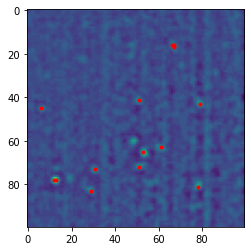

-0.0007 2.0180930379940363 39


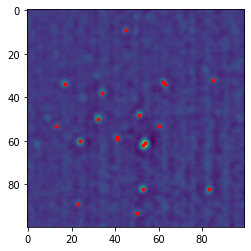

0.0043 1.954298214193525 29


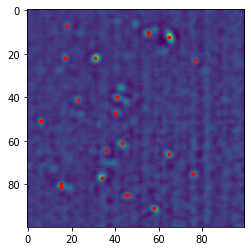

0.005 2.2094286591786574 26


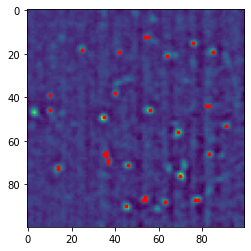

-0.0011 2.635583197320851 41


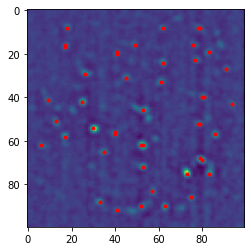

0.0072 2.553693043417709 27


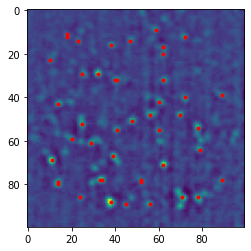

0.005 3.1149919743074785 36


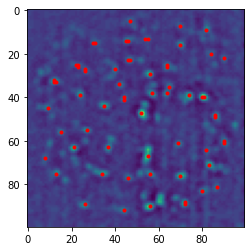

0.0083 3.1703676616443084 31


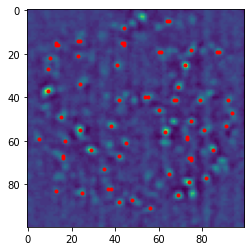

0.0035 4.071398746131359 54


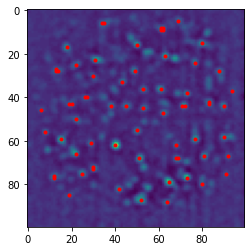

0.002 4.582400680865871 68


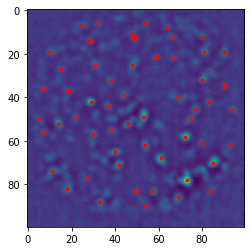

-0.0019 5.4070043822804505 44


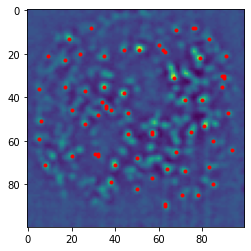

-0.0066 6.287014906933178 76


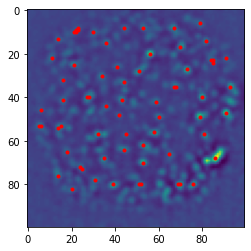

-0.0069 7.424341882618283 92


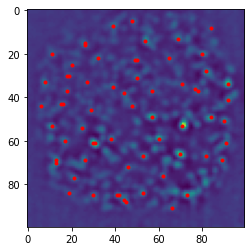

-0.0016 8.472779794140765 77


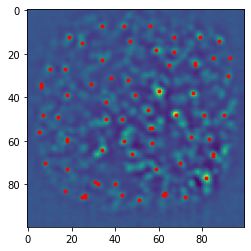

-0.0049 10.315710154419811 138


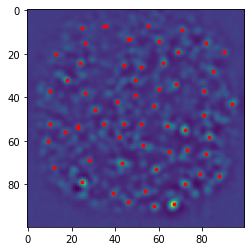

In [271]:
dif_gauss_sigma=(1, 3)
min_distance=5
well = crop(rfp_z_sum, centers[73]['center'], 100)
image_ref = ndi.gaussian_filter(well[0], sigma=dif_gauss_sigma[0]) - ndi.gaussian_filter(well[0], sigma=dif_gauss_sigma[1])
print(image_ref.mean(), image_ref.std(), image_ref.max())

for im in well[1:]:
    image_max = ndi.gaussian_filter(im, sigma=dif_gauss_sigma[0]) - ndi.gaussian_filter(im, sigma=dif_gauss_sigma[1])
    print(image_max.mean(), image_max.std(), image_max.max())
    peaks = peak_local_max(image_max, min_distance=min_distance, threshold_abs=5)
    
    if True:
        plt.imshow(image_max)
        plt.plot(peaks[:,1], peaks[:,0], 'r.')
        plt.show()

In [71]:
peaks = count.get_peaks_all_wells(rfp_z_sum, centers, 100)

................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [72]:
len(peaks)

496

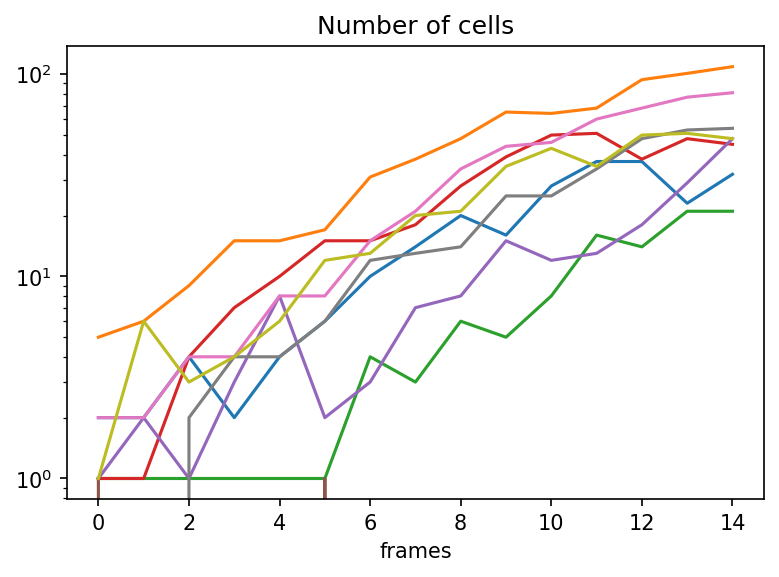

In [95]:
plt.figure(dpi=150)
[plt.semilogy(p[:15], alpha=1) for p in peaks[:9]]
plt.title('Number of cells')
plt.xlabel('frames')
plt.show()

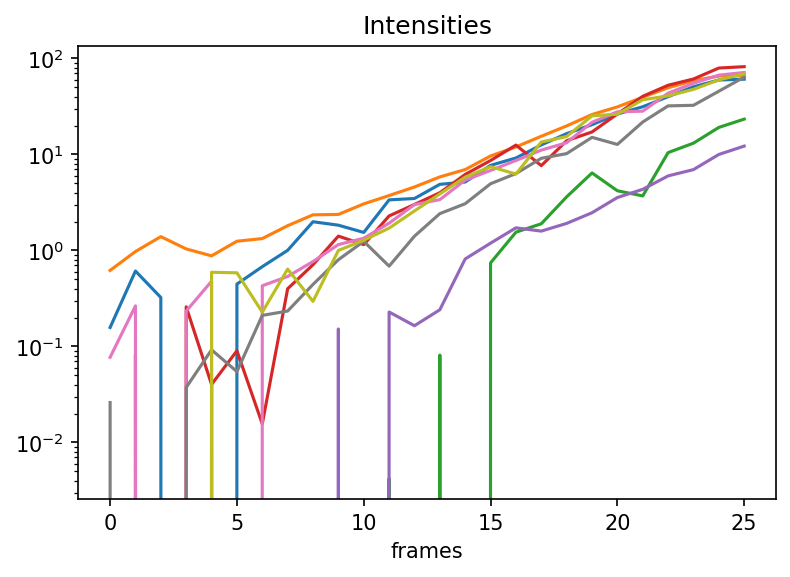

In [96]:
plt.figure(dpi=150)
[plt.semilogy(all_fits.query(f'id == {i}').curve.values[0]) for i in range(1,10)]
plt.title('Intensities')
plt.xlabel('frames')
plt.show()

In [86]:
all_fits.query(f'id == 1').curve.values[0]

array([ 1.57726671e-01,  6.10913006e-01,  3.23733523e-01, -1.80996243e-02,
       -2.07671792e-02,  4.46402971e-01,  6.78120208e-01,  1.00309538e+00,
        1.99068865e+00,  1.83392012e+00,  1.54060156e+00,  3.36431698e+00,
        3.47821464e+00,  4.88311321e+00,  5.16375339e+00,  7.69892409e+00,
        9.18466563e+00,  1.25672206e+01,  1.64709422e+01,  2.04332140e+01,
        2.63528011e+01,  3.13795642e+01,  3.99830302e+01,  5.06941313e+01,
        5.96157835e+01,  6.08182587e+01])

In [397]:
n_cells = [np.mean(nums[:5]).astype(int) for nums in peaks]

Text(0.5, 1.0, 'automatic detections')

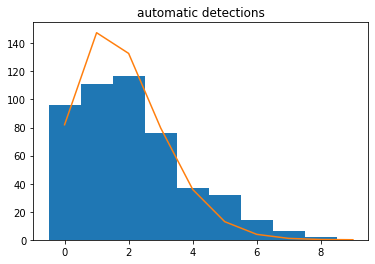

In [409]:
from scipy.stats import poisson

l=1.8

plt.hist(n_cells, bins=np.arange(10)-0.5, density=False)
plt.plot(np.arange(10), 496 * poisson.pmf(np.arange(10), l))
plt.title('automatic detections')

In [314]:
np.argmax(n_cells)

112

In [315]:
max(n_cells)

17

In [316]:
peaks[112]

[17,
 7,
 2,
 4,
 6,
 5,
 3,
 11,
 10,
 14,
 9,
 10,
 14,
 22,
 40,
 49,
 47,
 43,
 45,
 57,
 55,
 45,
 52,
 44,
 48,
 48]

In [365]:
h, bins, _ = plt.hist([c['center'][0] for c in centers], bins=np.arange(3000, step=20))
from scipy.signal import find_peaks
pks = find_peaks(h)[0]
print(len(pks))
plt.plot(bins[pks], h[pks],'x')
plt.show()

13


In [347]:
plt.figure(figsize=(20,5))
plt.hist([c['center'][1] for c in centers], bins=153)
plt.show()

(array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22]), {})

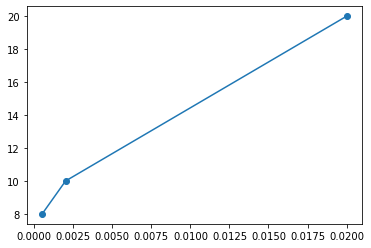

In [99]:
plt.plot([5e-4, 2e-3, .02], [8, 10, 20], 'o-')

In [100]:
plt.semilogx([5e-4, 2e-3, .02], [8, 10, 20], 'o-')